### Data Preparation

In [181]:
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

In [182]:
df = pd.read_csv("../Data_Analysis/cluster_1_family_AUTOMOTIVE.csv", parse_dates=["date"])

df = df.sort_values("date")

In [183]:
full_dates = pd.date_range(start=df["date"].min(), end=df["date"].max())

store_item_combinations = df[["store_nbr", "item_nbr"]].drop_duplicates()

full_data = pd.MultiIndex.from_product([full_dates, store_item_combinations["store_nbr"], store_item_combinations["item_nbr"]],
                                       names=["date", "store_nbr", "item_nbr"]).to_frame(index=False)

df_filled = full_data.merge(df, on=["date", "store_nbr", "item_nbr"], how="left")

df_filled["unit_sales"] = df_filled["unit_sales"].fillna(0)

# Creating lag features
df_filled["lag_7"] = df_filled.groupby(["store_nbr", "item_nbr"])["unit_sales"].shift(7)
df_filled["lag_14"] = df_filled.groupby(["store_nbr", "item_nbr"])["unit_sales"].shift(14)
df_filled["rolling_mean_7"] = df_filled.groupby(["store_nbr", "item_nbr"])["unit_sales"].shift(1).rolling(7).mean()

# Dropping rows with NaN values that was created by the lag features
df_filled = df_filled.dropna()

# Encoding categorical variables
df_filled["store_nbr"] = df_filled["store_nbr"].astype("category")
df_filled["item_nbr"] = df_filled["item_nbr"].astype("category")
df_filled["onpromotion"] = df_filled["onpromotion"].astype(int)

copy_of_df_filled = df_filled.copy()

df_filled.drop(columns=["id", "city", "state", "type", "cluster", "family", "class", "onpromotion", "avg_unit_sales"], inplace=True)

In [184]:
df_filled

,date,store_nbr,item_nbr,unit_sales,perishable,lag_7,lag_14,rolling_mean_7
225,2013-01-02,27,121964,1.0,0.0,1.0,1.0,0.857143
233,2013-01-02,27,1009512,2.0,0.0,2.0,2.0,0.571429
234,2013-01-02,27,270522,2.0,0.0,2.0,2.0,0.857143
235,2013-01-02,27,461432,1.0,0.0,1.0,1.0,0.714286
244,2013-01-02,27,312317,1.0,0.0,1.0,1.0,0.142857
...,...,...,...,...,...,...,...,...
3119250,2017-08-15,25,1969477,1.0,0.0,1.0,1.0,0.285714
3119251,2017-08-15,25,1969863,2.0,0.0,2.0,2.0,0.571429
3119254,2017-08-15,25,1969477,1.0,0.0,1.0,1.0,0.714286
3119260,2017-08-15,25,1969863,2.0,0.0,2.0,2.0,0.428571


In [185]:
train = df_filled[df_filled["date"] < "2017-07-01"]
test = df_filled[df_filled["date"] >= "2017-07-01"]

X_train = train.drop(columns=["unit_sales", "date"])
y_train = train["unit_sales"]

X_test = test.drop(columns=["unit_sales", "date"])
y_test = test["unit_sales"]

In [186]:
X_train

,store_nbr,item_nbr,perishable,lag_7,lag_14,rolling_mean_7
225,27,121964,0.0,1.0,1.0,0.857143
233,27,1009512,0.0,2.0,2.0,0.571429
234,27,270522,0.0,2.0,2.0,0.857143
235,27,461432,0.0,1.0,1.0,0.714286
244,27,312317,0.0,1.0,1.0,0.142857
...,...,...,...,...,...,...
3034132,25,312317,0.0,1.0,1.0,0.285714
3034152,25,312317,0.0,1.0,1.0,0.142857
3034169,25,312317,0.0,1.0,1.0,0.142857
3034175,25,312317,0.0,1.0,1.0,0.285714


In [187]:
X_test

,store_nbr,item_nbr,perishable,lag_7,lag_14,rolling_mean_7
3034209,24,121964,0.0,0.0,0.0,0.000000
3034210,24,121964,0.0,0.0,0.0,0.142857
3034219,24,121964,0.0,0.0,0.0,0.285714
3034232,24,1903432,0.0,0.0,0.0,0.000000
3034235,24,1903432,0.0,0.0,0.0,0.428571
...,...,...,...,...,...,...
3119250,25,1969477,0.0,1.0,1.0,0.285714
3119251,25,1969863,0.0,2.0,2.0,0.571429
3119254,25,1969477,0.0,1.0,1.0,0.714286
3119260,25,1969863,0.0,2.0,2.0,0.428571


### Model Training

In [188]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

future_dates = pd.date_range(start=test["date"].min(), periods=45)
forecast_results = []

store_item_groups = X_test.groupby(["store_nbr", "item_nbr"])

for (store, item), group in store_item_groups:
    X_test_subset = group.copy()
    
    for i in range(45):
        prediction = model.predict(X_test_subset.iloc[[i]])[0]
        
        forecast_results.append({"date": future_dates[i], "store_nbr": store, "item_nbr": item, "predicted_sales": prediction})
        
        if i + 7 < len(X_test_subset):
            X_test_subset.iloc[i + 7, X_test_subset.columns.get_loc("lag_7")] = prediction
        if i + 14 < len(X_test_subset):
            X_test_subset.iloc[i + 14, X_test_subset.columns.get_loc("lag_14")] = prediction

forecast_df = pd.DataFrame(forecast_results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 481167, number of used features: 5
[LightGBM] [Info] Start training from score 1.456095


C:\Users\Tharusha\AppData\Local\Temp\ipykernel_48016\2623748246.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  store_item_groups = X_test.groupby(["store_nbr", "item_nbr"])


In [189]:
y_test

3034209    1.0
3034210    1.0
3034219    1.0
3034232    2.0
3034235    2.0
          ... 
3119250    1.0
3119251    2.0
3119254    1.0
3119260    2.0
3119261    1.0
Name: unit_sales, Length: 20091, dtype: float64

In [190]:
forecast_df

,date,store_nbr,item_nbr,predicted_sales
0,2017-07-01,24,121964,1.323234
1,2017-07-02,24,121964,1.063245
2,2017-07-03,24,121964,1.364925
3,2017-07-04,24,121964,1.666977
4,2017-07-05,24,121964,1.666977
...,...,...,...,...
1750,2017-08-10,27,1969899,2.009643
1751,2017-08-11,27,1969899,2.841542
1752,2017-08-12,27,1969899,2.009643
1753,2017-08-13,27,1969899,1.978105


In [191]:
prediction = forecast_df["predicted_sales"]

In [192]:
feature_importances = model.feature_importances_

feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

          Feature  Importance
5  rolling_mean_7        1323
3           lag_7         843
1        item_nbr         414
4          lag_14         251
0       store_nbr         169
2      perishable           0


In [193]:
actual_df = copy_of_df_filled.rename(columns={"unit_sales": "actual_sales"})

merged_df = actual_df.merge(forecast_df, on=["date", "store_nbr", "item_nbr"], how="left")

merged_df = merged_df.dropna()

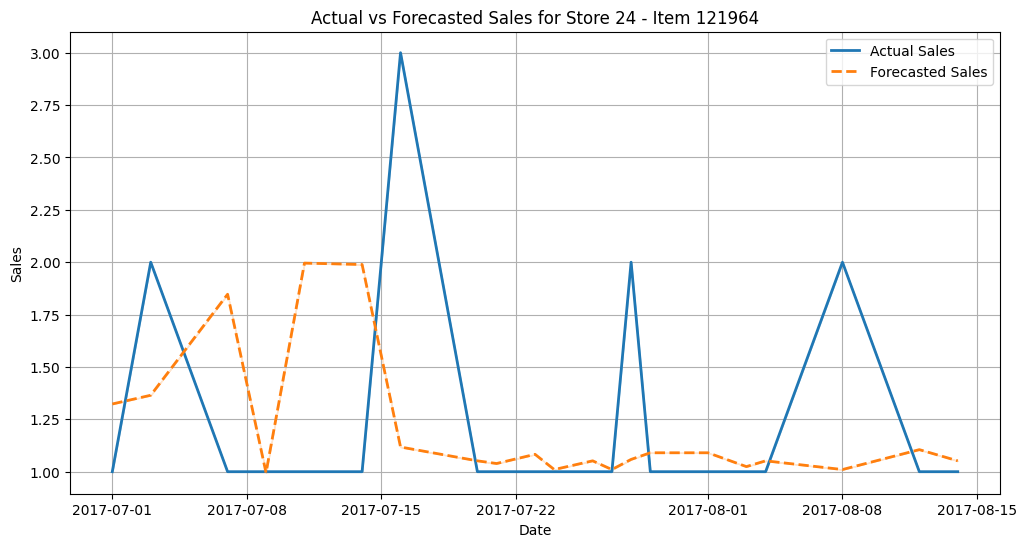

In [ ]:
store_id = 24
item_id = 121964

subset_df = merged_df[(merged_df["store_nbr"] == store_id) & (merged_df["item_nbr"] == item_id)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=subset_df, x="date", y="actual_sales", label="Actual Sales", linewidth=2)
sns.lineplot(data=subset_df, x="date", y="predicted_sales", label="Forecasted Sales", linestyle="dashed", linewidth=2)

plt.title(f"Actual vs Forecasted Sales for Store {store_id} - Item {item_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()
